In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

Read each fitting results file and print the fitting criteria and mean parameters

In [2]:
DATA_DIR = "../../data/fitting_results"
FIGURE_DIR = "../../figures"
all_model_dfs = {}
for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
    df = pd.read_csv(f"{DATA_DIR}/fitting_results_{agent_type}.csv")
    print(f"agent type: {agent_type}, n={len(df)}")
    all_model_dfs[agent_type] = df
    print(f"{agent_type} llh: {df['ll'].sum()}")
    print(f"{agent_type} AIC: {df['AIC'].sum()}")
    print(f"{agent_type} llh mean: {df['ll'].mean()}")
    print(f"{agent_type} AIC mean: {df['AIC'].mean()}")
    if agent_type in ('sparse_max_discrete', 'sparse_max_continuous'):
        print("attention cost")
        print(df['attention_cost'].mean())
        print(df['attention_cost'].std())
        print("step size")
        print(df['step_size'].mean())
        print(df['step_size'].std())
    elif agent_type == "nul_model_1":
        print("n")
        print(df['n'].mean())
        print("b")
        print(df['b'].mean())
    print(df.mean())

agent type: lqr, n=111
lqr llh: -13578.071309999998
lqr AIC: 27600.142619999995
lqr llh mean: -122.32496675675671
lqr AIC mean: 248.64993351351342
Unnamed: 0        0.000000
Unnamed: 0.1      0.000000
exp_param         0.009410
vm_param          1.455087
ll             -122.324967
AIC             248.649934
dtype: float64
agent type: sparse_lqr, n=111
sparse_lqr llh: -9131.236567000002
sparse_lqr AIC: 18706.473134000003
sparse_lqr llh mean: -82.2633924954955
sparse_lqr AIC mean: 168.526784990991
Unnamed: 0          0.000000
Unnamed: 0.1        0.000000
attention_cost    112.040393
exp_param           0.046089
vm_param            3.900344
ll                -82.263392
AIC               168.526785
dtype: float64
agent type: sparse_max_discrete, n=111
sparse_max_discrete llh: -8600.97743
sparse_max_discrete AIC: 18089.95486
sparse_max_discrete llh mean: -77.48628315315312
sparse_max_discrete AIC mean: 162.97256630630625
attention cost
13.411254161341182
9.898086660220018
step size
0.450149

In [3]:
pp_nrs = pd.read_csv('../../data/experimental_data/experiment_ppids.csv')['id']

Get the number of participants best fit by each model, as well as the strength of evidence for the best model over the second-best model for each participant

In [4]:
evidence_strengths = []
evidence_vs_lqr = []
models_by_best_fitting_pps = defaultdict(int)
participant_to_best_model = {}
for pp_id in pp_nrs:
    participant_fits = {}
    for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
        df = all_model_dfs[agent_type]

        if len(df[df['pp_id'] == pp_id]['AIC']) != 1:
            print("len:", len(df[df['pp_id'] == pp_id]['AIC']))
            break
        participant_fits[agent_type] = int(df[df['pp_id'] == pp_id]['AIC'])

    if len(df[df['pp_id'] == pp_id]) != 1:
        continue
    
    sorted_fits = sorted(participant_fits.values())
    evidence_strengths.append(sorted_fits[1] - sorted_fits[0])
    best_agent = min(participant_fits, key=participant_fits.get)
    
    evidence_vs_lqr.append(participant_fits['lqr'] - participant_fits[best_agent])
    
    models_by_best_fitting_pps[best_agent] += 1
    participant_to_best_model[pp_id] = best_agent

print(models_by_best_fitting_pps)

defaultdict(<class 'int'>, {'null_model_2': 4, 'sparse_max_discrete': 35, 'sparse_lqr': 24, 'sparse_max_continuous': 11, 'hill_climbing': 30, 'null_model_1': 7})


Create csv files for Bayesian model selection (done using SPM8)

In [5]:
df_aics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert AICs to log model evidence format
    df_aics[df_type] = all_model_dfs[df_type]['AIC'].apply(lambda x: -x/2)
df_aics.to_csv(f"{DATA_DIR}/aic_lme.csv")

n_params = {"null_model_2": 2, "null_model_1": 2, "lqr": 2, "sparse_lqr": 3, "hill_climbing": 3, "sparse_max_continuous": 4, "sparse_max_discrete": 4}
df_bics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert BICs to log model evidence format
    df_bics[df_type] = all_model_dfs[df_type]["ll"].apply(lambda x: - (n_params[df_type] * np.log(10) - 2 * x) / 2)
df_bics.to_csv(f"{DATA_DIR}/bic_lme.csv")

In [6]:
# make a csv file with the best-fitting model and parameters for each participant
df_bestfit = pd.DataFrame()
for pp_id in pp_nrs:
    best_model_type = participant_to_best_model[pp_id]
    df = all_model_dfs[best_model_type]
    row = df[df['pp_id'] == pp_id]
    df_bestfit = df_bestfit.append(row, ignore_index=True)
df_bestfit.to_csv(f"{DATA_DIR}/best_fitting_models.csv")

Get the mean best-fitting parameter for each model type

In [7]:
for model_type in df_bestfit['agent_type'].drop_duplicates():
    df_model = df_bestfit[df_bestfit['agent_type'] == model_type]
    print(f"MODEL TYPE: {model_type}")
    print(f"exp param: {df_model['exp_param'].mean()}")
    print(f"vm param: {df_model['vm_param'].mean()}")
    print(f"step size: {df_model['step_size'].mean()}")
    print(f"attention cost: {df_model['attention_cost'].mean()}")
    print(f"n: {np.round(df_model['n']).mean()}")
    print(f"b: {df_model['b'].mean()}")

MODEL TYPE: null_model_2
exp param: 0.04663566551684295
vm param: 8.50941061248169
step size: nan
attention cost: nan
n: nan
b: nan
MODEL TYPE: sparse_max_discrete
exp param: 0.12631408576626565
vm param: 3.637073872971892
step size: 0.7175506759987064
attention cost: 13.995202652672416
n: nan
b: nan
MODEL TYPE: sparse_lqr
exp param: 0.0481132846814488
vm param: 4.285073238908963
step size: nan
attention cost: 104.28922234527384
n: nan
b: nan
MODEL TYPE: sparse_max_continuous
exp param: 0.026121032105562773
vm param: 5.902416820319927
step size: 0.257154795295051
attention cost: 7.549463573689025
n: nan
b: nan
MODEL TYPE: hill_climbing
exp param: 0.05193277024070883
vm param: 5.765847473581155
step size: 0.4342403209526937
attention cost: 0.0
n: nan
b: nan
MODEL TYPE: null_model_1
exp param: 0.07599924320574154
vm param: 6.124787996486719
step size: nan
attention cost: nan
n: 1.8571428571428572
b: 2.0630009219140084


In [8]:
# print the mean evidence strength (difference in AIC between top two models for a given participant)
print(np.mean(evidence_strengths))
print(np.std(evidence_strengths))

7.900900900900901
8.476735470298847


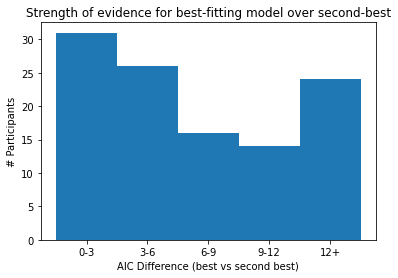

In [9]:
bins=(0,3,6,9,12,15)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_strengths, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(1.5,15,3))
ax.set_xticklabels(("0-3", "3-6", "6-9", "9-12", "12+"))
ax.set_xlabel("AIC Difference (best vs second best)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over second-best")
fig.savefig("../../figures/evidence_strength_best_second.pdf", bbox_inches="tight")

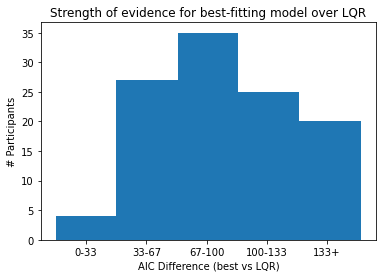

In [10]:
bins=(0,33,67,100,133,167)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_vs_lqr, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(16.5,167,33))
ax.set_xticklabels(("0-33", "33-67", "67-100", "100-133", "133+"))
ax.set_xlabel("AIC Difference (best vs LQR)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over LQR")
fig.savefig("../../figures/evidence_strength_best_lqr.pdf", bbox_inches="tight")

In [11]:
np.mean(evidence_vs_lqr)

93.55855855855856

In [12]:
len([x for x in evidence_vs_lqr if x <= -16])

0

In [13]:
len([x for x in evidence_strengths if x <= -4])

0

In [14]:
best_fit_pps = {}
for agent_type in ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']:
    best_fit_pps[agent_type] = [pp_id for pp_id in pp_nrs if participant_to_best_model[pp_id] == agent_type]

In [15]:
non_null_agent_types = ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']

## Qualitative Analysis

In [16]:
raw_pp_data_path = '../../data/experimental_data/experiment_actions.csv'
df_pps = pd.read_csv(raw_pp_data_path)

In [17]:
df_last = df_pps.loc[df_pps.groupby("pp_id")['Unnamed: 0'].idxmax()]

Get scores by which model explains each pp best

In [18]:
scores_by_best_model = defaultdict(list)
for index, row in df_last.iterrows():
    scores_by_best_model[participant_to_best_model[row['pp_id']]].append(np.sqrt(row['total_cost']))

In [19]:
for m in scores_by_best_model:
    print(f"{m} median: {np.median(scores_by_best_model[m])}")
    print(f"{m} mean: {np.mean(scores_by_best_model[m])}")
    print(f"m sem: {stats.sem(scores_by_best_model[m])}")

sparse_lqr median: 113.42391019621554
sparse_lqr mean: 117.22157716585758
m sem: 17.188483269475075
sparse_max_continuous median: 129.1218804076211
sparse_max_continuous mean: 229.4426868220407
m sem: 91.02906769032685
sparse_max_discrete median: 80.12159509146083
sparse_max_discrete mean: 98.64964625226861
m sem: 16.621387844161298
null_model_1 median: 143.8314291106085
null_model_1 mean: 221.9106576723773
m sem: 71.18860597700859
hill_climbing median: 161.291112641047
hill_climbing mean: 386.0149265320375
m sem: 224.50763457523615
null_model_2 median: 601.0280827355973
null_model_2 mean: 23203.244891505263
m sem: 22743.213179044094


In [20]:
np.median(scores_by_best_model['sparse_lqr'])

113.42391019621554

In [21]:
np.median(scores_by_best_model['hill_climbing'])

161.291112641047

In [22]:
len(scores_by_best_model['sparse_lqr'])

24

In [23]:
stats.kruskal(scores_by_best_model['sparse_lqr'], scores_by_best_model['hill_climbing'])

KruskalResult(statistic=4.291212121212112, pvalue=0.0383098441087415)

Get descriptive stats like number of variables manipulated.

In [24]:
print(len(scores_by_best_model['sparse_lqr']) + len(scores_by_best_model['hill_climbing']))

54


Compute the number of variables manipulated and input norm standard deviation for humans.

In [25]:
n_variables_manipulated = []
n_all_zero = 0
norms = []
for index, row in df_pps.iterrows():
    exogenous = literal_eval(row['exogenous_input'])
    n_manipulated = len([x for x in exogenous if x != 0])
    if exogenous == [0., 0., 0., 0.]:
        n_all_zero += 1
    n_variables_manipulated.append(n_manipulated)
    norms.append(sum([x**2 for x in exogenous]))
    
mean_manip = np.mean(n_variables_manipulated)
ci_manip = 1.96 *stats.sem(n_variables_manipulated)
print(f"mean number of variables manipulated: {mean_manip}")
print(f"95% CI number of variables manipulated: {(mean_manip - ci_manip, mean_manip + ci_manip)}")
print(f"median number of variables manipulated: {np.median(n_variables_manipulated)}")
print(f"iqr number of variables manipulated: {stats.iqr(n_variables_manipulated)}")
print(f"number of all zero inputs: {n_all_zero}")
print(f"norm med: {np.median(norms)}")
print(f"norm iqr: {stats.iqr(norms)}")
print(f"norm std: {np.std(norms)}")

mean number of variables manipulated: 2.0631199278629397
95% CI number of variables manipulated: (1.99701877926644, 2.1292210764594395)
median number of variables manipulated: 2.0
iqr number of variables manipulated: 2.0
number of all zero inputs: 56
norm med: 134.0
norm iqr: 759.0
norm std: 3482646.332299877


In [26]:
all_norm_meds = []
all_norm_stds = []
for pp in df_pps['pp_id'].drop_duplicates():
    norms = []
    for index, row in df_pps[df_pps['pp_id'] == pp].iterrows():
        exogenous = literal_eval(row['exogenous_input']) 
        norm = np.sqrt(sum([x**2 for x in exogenous]))
        norms.append(norm)
    # print(f"median norm: {np.median(norms)}")
    # print(f"std norm: {np.std(norms)}")
    all_norm_stds.append(np.std(norms))
    all_norm_meds.append(np.median(norms))

In [27]:
np.median(all_norm_meds)

11.269078289549748

In [28]:
np.median(all_norm_stds)

14.681139904908841